# Team Shape Analyzer  
**Martin Steglich**  


This notebook was developed as part of the  
**SkillCorner × PySport Analytics Cup (Analyst Track)**  
and analyses collective team shape using tracking data.


## Goal

The goal of this notebook is to demonstrate the proposed methodology using a single 
match as an illustrative example.

This analysis explores how a team's collective spatial structure changes across 
different phases of play within a single match, using geometrical metrics such as 
width, depth, and compactness.

## Match and Team Context

This analysis focuses on the match **Melbourne City vs Macarthur FC** from the SkillCorner
Open Data set. The collective spatial behaviour of **Melbourne City** is analysed
throughout the match, comparing its structure in and out of possession.

In [1]:
from src import preprocessing
from src import metrics
from src import timeline
from src import visualizations
from src import phases
from src import shape

import numpy as np
import pandas as pd

## Data Preparation

The tracking data is preprocessed and filtered to focus on a single team
within the selected match. The dataset is converted into a dataframe where
each player occupies a single row per frame. All positional coordinates are
transformed so that the analysed team always attacks in the same direction.

The resulting dataset is further enriched with additional contextual and
derived information, including:
- Phases of play provided in the SkillCorner Open Data set
- Preprocessed time variables, including time in seconds since match start
  and a corresponding `Timedelta` column
- An *in possession* indicator
- Ball zone annotations derived from the ball position
- Exclusion of the goalkeeper from the analysis

In [2]:
match_id = 2006229
team_id = 2380
is_home = True
df = preprocessing.prepare_team_tracking(match_id, team_id, is_home_team=is_home)
df.head()

/Users/martin/Documents/Projects/SkillCornerHackaton/analytics_cup_analyst/src/preprocessing.py:194: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_gk_for_frame)


,frame_id,timestamp,period_id,ball_state,ball_owning_team_id,ball_x,ball_y,player_id,x,y,...,possession_ends_in_opponent_box,possession_ends_in_team_box,possession_starts_in_opponent_box,possession_starts_in_team_box,match_time_s,match_time_td,in_possession,ball_zone_x,ball_zone_y,ball_zone_label
0,18,0 days 00:00:00.800000,1,alive,1804,0.78,0.68,7252,-9.57,-4.63,...,False,False,False,False,0.8,0 days 00:00:00.800000,False,1,1,2C
1,18,0 days 00:00:00.800000,1,alive,1804,0.78,0.68,9520,-18.01,3.81,...,False,False,False,False,0.8,0 days 00:00:00.800000,False,1,1,2C
2,18,0 days 00:00:00.800000,1,alive,1804,0.78,0.68,11891,-17.14,20.92,...,False,False,False,False,0.8,0 days 00:00:00.800000,False,1,1,2C
3,18,0 days 00:00:00.800000,1,alive,1804,0.78,0.68,26095,-0.93,8.16,...,False,False,False,False,0.8,0 days 00:00:00.800000,False,1,1,2C
4,18,0 days 00:00:00.800000,1,alive,1804,0.78,0.68,50992,-8.70,4.41,...,False,False,False,False,0.8,0 days 00:00:00.800000,False,1,1,2C


Before proceeding with the analysis, a few basic checks are performed to
ensure the data has been loaded and preprocessed correctly.

In [3]:
df.shape

(159325, 53)

In [4]:
df[["frame_id", "player_id", "x", "y", "in_possession"]].head()

,frame_id,player_id,x,y,in_possession
0,18,7252,-9.57,-4.63,False
1,18,9520,-18.01,3.81,False
2,18,11891,-17.14,20.92,False
3,18,26095,-0.93,8.16,False
4,18,50992,-8.70,4.41,False


In [5]:
df["period_id"].value_counts()

period_id
1    82990
2    76335
Name: count, dtype: int64

## Methodology

This analysis focuses on describing the collective spatial organisation of
the team using geometrical metrics derived from player positions. These
metrics are computed on a frame-by-frame basis and aggregated according to
different contextual filters, allowing comparisons between different states
within the match.

### Metrics Overview

The following geometrical metrics are used to describe the collective spatial
structure of the team:
- **Width**: horizontal spread of the team, measuring how much space is
  occupied across the pitch width.
- **Depth**: vertical spread of the team, capturing how stretched the team is
  along the length of the pitch.
- **Compactness**: area of the convex hull formed by player positions,
  representing how concentrated or dispersed the team shape is. The convex
  hull corresponds to the smallest polygon enclosing all player positions.
- **Team Centroid**: average position of all outfield players, used to
  represent the centre of the team block.
- **Ball–Centroid Distance**: distance between the team centroid and the ball,
  providing contextual information about the team’s spatial relation to ball
  location.
- **Line Height**: average longitudinal position of the deepest 20th
  percentile of outfield players, representing how deep the team is.
- **Block Height**: average longitudinal position of the most advanced 80th
  percentile of outfield players, representing how high the team presses.
- **Team Spread**: average distance between outfield players and the team
  centroid, describing the internal dispersion of the team.

## Frame-level Team Shape Metrics

Based on the methodology described above, team shape metrics are computed on
a frame-by-frame basis throughout the match. This representation allows the
analysis of both aggregated behaviour and temporal dynamics.

In [6]:
df_metrics = metrics.compute_match_metrics_by_frame(df)
df_metrics.head()

,compactness,width,depth,block_height,line_height,team_centroid_x,team_centroid_y,team_spread,n_players_used,centroid_ball_dist,...,possession_start_team_channel,possession_end_team_channel,possession_lead_to_shot,possession_lead_to_goal,team_loss_in_possession,team_recovery_in_possession,possession_ends_in_opponent_box,possession_ends_in_team_box,possession_starts_in_opponent_box,possession_starts_in_team_box
0,612.01030,38.99,17.62,-2.218,-17.314,-9.622,0.202,15.095730,10,10.412977,...,center,half_space_right,False,False,False,True,False,False,False,False
1,622.78985,39.09,17.77,-2.100,-17.368,-9.581,0.141,15.168931,10,12.701761,...,center,half_space_right,False,False,False,True,False,False,False,False
2,637.05530,39.34,18.10,-1.896,-17.428,-9.522,0.053,15.241007,10,15.522002,...,center,half_space_right,False,False,False,True,False,False,False,False
3,654.39960,39.58,18.63,-1.652,-17.494,-9.443,-0.026,15.322412,10,18.113005,...,center,half_space_right,False,False,False,True,False,False,False,False
4,674.73005,39.79,19.23,-1.362,-17.578,-9.357,-0.105,15.418401,10,20.407015,...,center,half_space_right,False,False,False,True,False,False,False,False


In [7]:
df_metrics.columns

Index(['compactness', 'width', 'depth', 'block_height', 'line_height',
       'team_centroid_x', 'team_centroid_y', 'team_spread', 'n_players_used',
       'centroid_ball_dist', 'frame_id', 'time', 'period_id', 'ball_x',
       'ball_y', 'ball_zone_x', 'ball_zone_y', 'ball_zone_label',
       'in_possession', 'possession_id', 'possession_duration_s',
       'team_phase_type', 'opponent_phase_type', 'possession_start_team_third',
       'possession_end_team_third', 'possession_start_team_channel',
       'possession_end_team_channel', 'possession_lead_to_shot',
       'possession_lead_to_goal', 'team_loss_in_possession',
       'team_recovery_in_possession', 'possession_ends_in_opponent_box',
       'possession_ends_in_team_box', 'possession_starts_in_opponent_box',
       'possession_starts_in_team_box'],
      dtype='object')

## Team Shape Metrics by Possession State
This section compares aggregated team shape metrics when the team is in and
out of possession, providing a first quantitative overview of structural
differences across contextual states.

For this analysis, a subset of the computed metrics is selected, focusing on
those that best capture collective spatial behaviour.

In [8]:
metrics_by_possession = (
    df_metrics
    .groupby("in_possession")
    .mean(numeric_only=True)
)

cols = [
    "width",
    "depth",
    "compactness",
    "team_spread",
]

metrics_by_possession[cols].round(2)

,width,depth,compactness,team_spread
in_possession,,,,
False,37.85,29.59,819.17,15.90
True,47.83,33.79,1180.11,19.32


As expected, when the team is out of possession it adopts a more compact
structure, occupying less horizontal and vertical space. In addition, the
reduced team spread indicates a lower internal dispersion between players,
reinforcing the interpretation of a compact defensive organisation.

## Average Team Shape by Possession State

To visually confirm the differences observed in the aggregated metrics, the
average team shape is computed and displayed separately for in-possession
and out-of-possession situations. These plots illustrate how the team
expands and contracts its spatial structure depending on the possession
state.

In [9]:
df_in_possession = df[df["in_possession"] == 1]
df_out_possession = df[df["in_possession"] == 0]
team_shape_in_possession = shape.compute_average_team_shape_segment(df_in_possession, top_n_players=10, include_metrics=True)
team_shape_out_possession = shape.compute_average_team_shape_segment(df_out_possession, top_n_players=10, include_metrics=True)


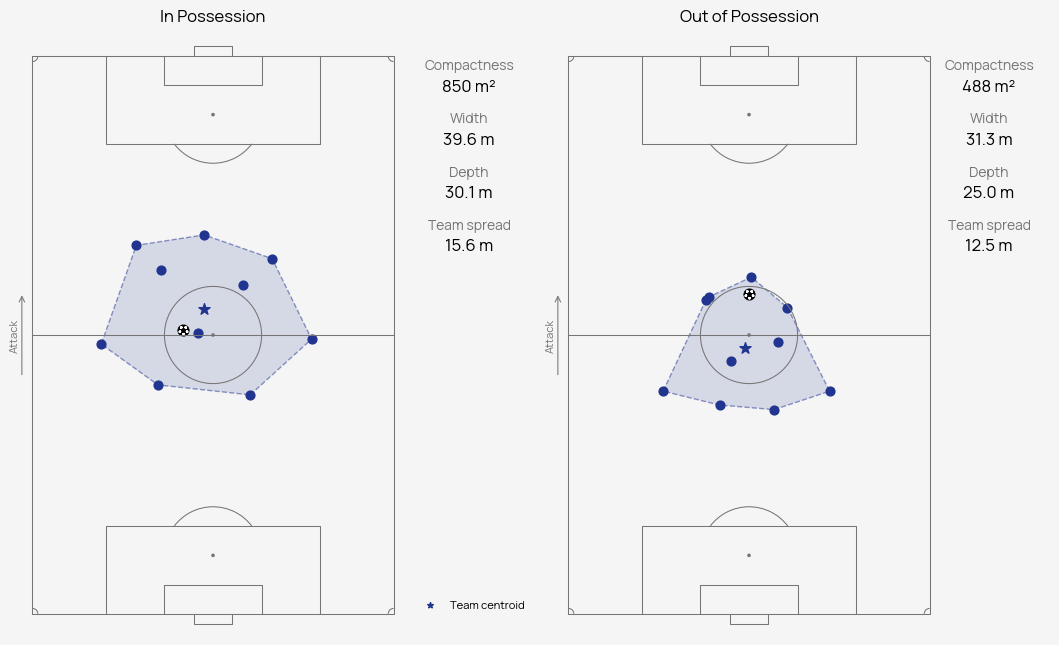

In [10]:
_ = visualizations.plot_comparission_shapes(team_shape_in_possession, team_shape_out_possession,
                                            vertical_pitch=True, 
                                            show_metrics=True, 
                                            metric_column='team_centroid', 
                                            titles=['In Possession', 'Out of Possession'], 
                                            in_possession=False, 
                                            is_submission=True)

## Team Shape During In-Possession Phases of Play

Beyond possession state, team shape can vary depending on the specific phase
of play. This section compares team shape during two contrasting in-possession phases:
positional attacks in the finishing phase and direct attacking situations
initiated from deeper areas.


In [11]:
metrics_by_phase = (
    df_metrics[
    (df_metrics["team_phase_type"].isin(["direct", "finish"])) &
    (df_metrics["in_possession"])]
    .groupby("team_phase_type")
    .mean(numeric_only=True)
)

cols = [
    "width",
    "depth",
    "compactness",
    "team_spread",
]

metrics_by_phase[cols].round(2)

,width,depth,compactness,team_spread
team_phase_type,,,,
direct,38.94,32.32,963.38,16.77
finish,45.65,33.58,1021.15,18.34


The table summarises the main geometrical metrics for the selected
in-possession phases, highlighting clear structural differences between
direct attacks and finishing situations.

In [12]:
df_direct = df_in_possession[df_in_possession.team_in_possession_phase_type == 'direct']
df_finish = df_in_possession[df_in_possession.team_in_possession_phase_type == 'finish']
team_shape_direct = shape.compute_average_team_shape_segment(df_direct, top_n_players=10, include_metrics=True)
team_shape_finish = shape.compute_average_team_shape_segment(df_finish, top_n_players=10, include_metrics=True)

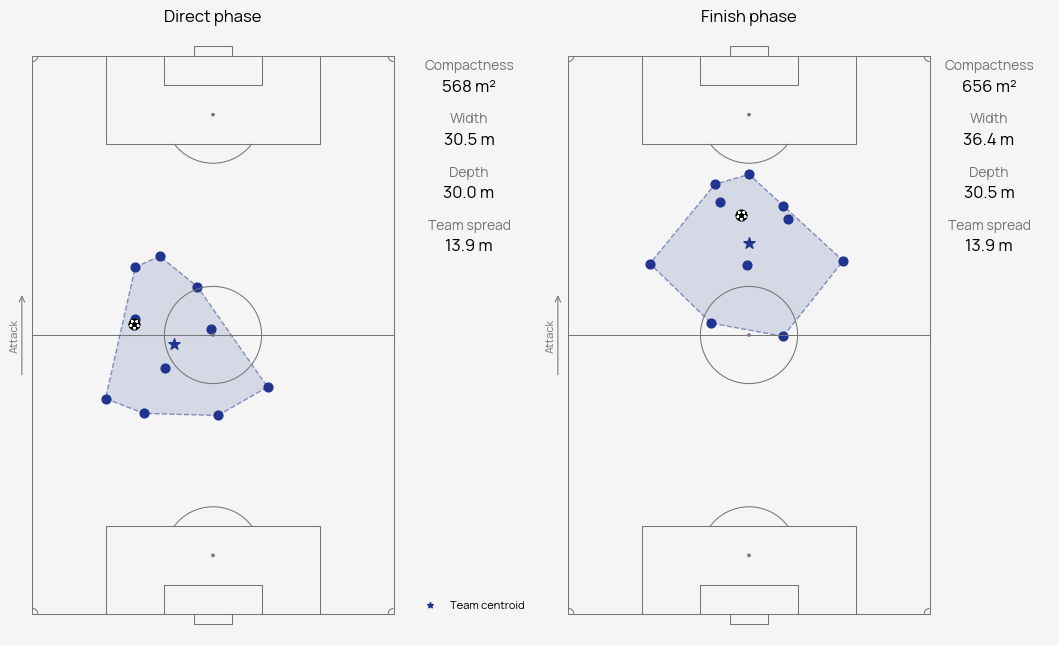

In [13]:
_ = visualizations.plot_comparission_shapes(team_shape_direct, team_shape_finish,
                                        vertical_pitch=True, 
                                        show_metrics=True, 
                                        metric_column='team_centroid', 
                                        titles=['Direct phase', 'Finish phase'], 
                                        in_possession=False, 
                                        is_submission=True)

These two phases highlight clear differences in team structure depending on the
attacking context. While direct attacks favour a narrower and more vertical
shape, finishing situations are characterised by wider and more compact
organisation. The following section examines how the finishing structure
changes in possessions that lead to shots or goals.

In [14]:
df_goal_shot = df_finish[(df_finish.possession_lead_to_shot == True) | (df_finish.possession_lead_to_goal == True)]
df_goal_shot_shape = shape.compute_average_team_shape_segment(df_goal_shot, top_n_players=10, include_metrics=True)

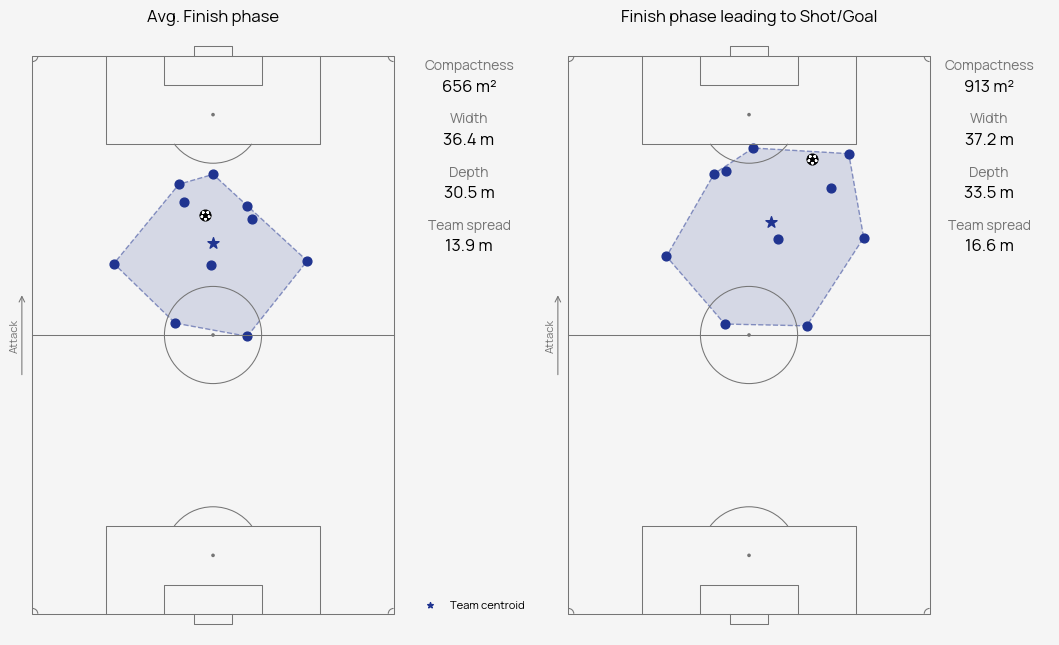

In [15]:
_ = visualizations.plot_comparission_shapes(team_shape_finish, df_goal_shot_shape,
                                            vertical_pitch=True, 
                                            show_metrics=True, 
                                            metric_column='team_centroid', 
                                            titles=['Avg. Finish phase', 'Finish phase leading to Shot/Goal'], 
                                            in_possession=False, 
                                            is_submission=True)

Finishing possessions that lead to shots or goals tend to be associated with a
more expanded and deeper team shape, suggesting a greater spatial occupation
around the ball compared to the average finishing structure.

## Key Insights

- Team shape differs markedly between possession states, with the team adopting
  a more compact and narrower structure when out of possession.
- In-possession phases present distinct spatial organisations, with direct
  attacks characterised by narrower and more vertical shapes compared to
  established finishing situations.
- Finishing phases are associated with wider and more compact
  structures, reflecting sustained possession in advanced areas.
- Possessions that lead to shots or goals display a more expanded and deeper
  team shape compared to the average finishing phase.
- While overall spatial occupation changes across contexts, internal player
  spacing remains relatively stable, indicating consistent inter-player
  distances.
- Combining tracking data with phases of play enables a richer description of
  collective team behaviour beyond simple possession-based analysis. 






